In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, linalg, csc_matrix
import scipy.sparse.linalg as sla
from scipy.interpolate import CubicSpline

In [2]:
### Functions

def Interpolation_to_2x_grid(data, NS):
#     Interpolation epsilon data to 2x grid for futher extracting data to ERxx, ERyy, ERzz, URxx, URyy, ERzz
#     Arguments:
#         data   2d numpy array of epsilon distribution
#         NS    [Nx, Ny] Grid Size
#     Returns:
#         data   2d numpy array of epsilon distribution for 2x grid

    Nx = int(NS[0])                                          # extract grid parameter at the x-axis
    Ny = int(NS[1])                                          # extract grid parameter at the y-axis  
    x_grid = np.linspace(0, Nx, Nx) 
    y_grid = np.linspace(0, Ny, Ny)

    # Interpolation to 2x grid
    Tx = np.linspace(0, Nx, 2*Nx)                            # x-axis for 2x grid
    Ty = np.linspace(0, Ny, 2*Ny)                            # y-axis for 2x grid
    cs1 = CubicSpline(x_grid, data, axis=0)
    eps2grid = cs1(Tx)
    cs2 = CubicSpline(y_grid, eps2grid, axis=1)
    eps2grid = cs2(Ty)
    
    return eps2grid


########################################################################################################################


def addupml2d(ER2, UR2, NPML):
#     Computes the Electric Permittivity and Magnetic Permeability on a 2xGrid after adding a Perfectly Matched Layer.
#     Arguments:
#         ER2 Relative permittivity on 2x grid
#         UR2 Relative permeability on 2x grid
#         NPML [NXLO, NXHI, NYLO, NYHI] Size of UPML on a 1x grid
#     Returns:
#         ERxx xx tensor element for relative electric permittivity
#         ERyy yy tensor element for relative electric permittivity
#         ERzz zz tensor element for relative electric permittivity
#         URxx xx tensor element for relative magnetic permeability
#         URyy yy tensor element for relative magnetic permeability
#         URzz zz tensor element for relative magnetic permeability
    
    # Define PML parameters (reference values)
    amax = 4                                      # maximum of amplitude
    cmax = 1                                      # maximum of conductivity
    p = 3                                         # power

    [Nx2, Ny2] = np.shape(ER2)                    # Extract grid parameters

    NXLO = 2 * NPML[0]                            # Extract PML parameters at the lower x-axis boundary
    NXHI = 2 * NPML[1]                            # Extract PML parameters at the upper x-axis boundary
    NYLO = 2 * NPML[2]                            # Extract PML parameters at the lower y-axis boundary
    NYHI = 2 * NPML[3]                            # Extract PML parameters at the upper y-axis boundary

    sx = np.ones((Nx2, Ny2), dtype=np.csingle)    # Calculate PML Parameters to problem space at the x-axis
    sy = np.ones((Nx2, Ny2), dtype=np.csingle)    # Calculate PML Parameters to problem space at the y-axis

    # Add XLO PML
    for i in range(NXLO):
        ax = 1 + (amax - 1) * ((i + 1) / NXLO) ** p
        cx = cmax * np.sin(0.5 * np.pi * (i + 1) / NXLO) ** 2
        sx[int(NXLO - (i + 1)), :] = ax * (1 - 1j * 60 * cx)

    # Add XHI PML
    for i in range(NXHI):
        ax = 1 + (amax - 1) * ((i + 1) / NXHI) ** p
        cx = cmax * np.sin(0.5 * np.pi * (i + 1) / NXHI) ** 2
        sx[int(Nx2 - NXHI + i), :] = ax * (1 - 1j * 60 * cx)

    # Add YLO PML
    for i in range(NYLO):
        ay = 1 + (amax - 1) * ((i + 1) / NYLO) ** p
        cy = cmax * np.sin(0.5 * np.pi * (i + 1) / NYLO) ** 2
        sy[:, int(NYLO - (i + 1))] = ay * (1 - 1j * 60 * cy)

    # Add YHI PML
    for i in range(NYHI):
        ay = 1 + (amax - 1) * ((i + 1) / NYHI) ** p
        cy = cmax * np.sin(0.5 * np.pi * (i + 1) / NYHI) ** 2
        sy[:, int(Ny2 - NYHI + i)] = ay * (1 - 1j * 60 * cy)

    # Calculate tensor elements with UPML
    ERxx = ER2 / sx * sy
    ERyy = ER2 * sx / sy
    ERzz = ER2 * sx * sy

    URxx = UR2 / sx * sy
    URyy = UR2 * sx / sy
    URzz = UR2 * sx * sy

    # Extract tensor elements on yee grid
    ERxx = ERxx[1:Nx2:2, 0:Ny2:2]
    ERyy = ERyy[0:Nx2:2, 1:Ny2:2]
    ERzz = ERzz[0:Nx2:2, 0:Ny2:2]

    URxx = URxx[0:Nx2:2, 1:Ny2:2]
    URyy = URyy[1:Nx2:2, 0:Ny2:2]
    URzz = URzz[1:Nx2:2, 1:Ny2:2]

    # Flatten to one dimension.
    ERxx = ERxx.flatten('F')
    ERyy = ERyy.flatten('F')
    ERzz = ERzz.flatten('F')
    URxx = URxx.flatten('F')
    URyy = URyy.flatten('F')
    URzz = URzz.flatten('F')

    # Calculating the multiplicative inverse of the permeability and permittivity matrices
    ERxx_i = 1 / ERxx
    ERyy_i = 1 / ERyy
    URxx_i = 1 / URxx
    URyy_i = 1 / URyy

    # Creating a Sparse Diagonal and transforming it to an array
    ERxx = diags(ERxx, 0)
    ERyy = diags(ERyy, 0)
    ERzz = diags(ERzz, 0)
    URxx = diags(URxx, 0)
    URyy = diags(URyy, 0)
    URzz = diags(URzz, 0)

    # Creating sparse diagonals of inverses
    ERxx_i = diags(ERxx_i, 0)
    ERyy_i = diags(ERyy_i, 0)
    URxx_i = diags(URxx_i, 0)
    URyy_i = diags(URyy_i, 0)

    return ERxx, ERyy, ERzz, URxx, URyy, URzz, ERxx_i, ERyy_i, URxx_i, URyy_i

########################################################################################################################


def yeeder2d(NS, RES, k=None):
#     Compute derivative matrices on a 2D Yee Grid according to Boundary Conditions
#     Arguments:
#         NS    [Nx, Ny] Grid Size
#         RES   [dx, dy] Grid Resolution
#         kinc  [kx, ky] Incident Wave Vector
#     Returns:
#         DEx spatial derivatives of the electric field across the x-axis
#         DEy spatial derivatives of the electric field across the y-axis
#         DHx spatial derivatives of the magnetic field across the x-axis
#         DHy spatial derivatives of the magnetic field across the y-axis

    Nx = int(NS[0])                          # extract grid parameter at the x-axis
    Ny = int(NS[1])                          # extract grid parameter at the y-axis     
    dx = RES[0]                              # extract resolution parameter at the x-axis
    dy = RES[1]                              # extract resolution parameter at the y-axis

    if k is None:                            # Define default indicent wave (k is only needed for periodic boundary conditions)
        k_incident = np.zeros(2)

    M = int(Nx * Ny)                         # Matrix size

    #BUILD DEX
    if Nx==1:
        DEx = -1j * k_incident[0] * np.eye(M)
    else:
        d0 = - np.ones(M)
        d1 = np.ones(M - 1)
        d1[range(Nx - 1, M - 1, Nx)] = 0
        DEx = (1 / dx) * diags([d0, d1], [0, 1])
        
    #BUILD DEY    
    if Ny == 1:
        DEy = -1j * k_incident[1] * np.eye(M)
    else:
        d0 = - np.ones(M)
        d1 = np.ones(int(M - Nx))
        DEy = (1 / dy) * diags([d0, d1], [0, Nx])

    # Build DHx and DHy
    DHx = - np.conjugate(DEx.transpose())
    DHy = - np.conjugate(DEy.transpose())

    # Transforming to sparse matrices
    DEx = csc_matrix(DEx)
    DEy = csc_matrix(DEy)
    DHx = csc_matrix(DHx)
    DHy = csc_matrix(DHy)
    
    return DEx, DEy, DHx, DHy


########################################################################################################################


def mode_source(coord, ER2, UR2, MODE, NMODES):
#   define mode source for waveguide by solving eigen-value problem 
#     Arguments:
#         coord    distance beetwen grid edge and mode source location 
#         ER2      Electric Permittivity of splitter at the 2x grid
#     Returns:
#         NEFF     Matrix of effective refractive indexes
#         Esrc     Matrix of fields correspond to effective refractive indexes
#         fscr_on_grid   Matrix of mode source field distribution on the grid

    nx   = 2*coord
    erzz = ER2[nx, 0:Ny2:2]                  # Define zz tensor element for relative electric permittivity for 1D grid
    urxx = UR2[nx, 1:Ny2:2]                  # Define xx tensor element for relative magnetic permeability for 1D grid
    uryy = UR2[nx+1, 0:Ny2:2]                # Define yy tensor element for relative magnetic permeability for 1D grid       

        
    # Flatten to one dimension
    erzz = erzz.flatten('F')
    urxx = urxx.flatten('F')
    uryy = uryy.flatten('F')
    
    # Calculating the multiplicative inverse of the permeability and permittivity matrices        
    erzz_i = 1 / erzz
    urxx_i = 1 / urxx
    uryy_i = 1 / uryy

    # Creating a Sparse Diagonal and transforming it to an array
    erzz = diags(erzz, 0)
    urxx = diags(urxx, 0)
    uryy = diags(uryy, 0)
        
    # Creating sparse diagonals of inverses        
    erzz_i = diags(erzz_i, 0)
    urxx_i = diags(urxx_i, 0)
    uryy_i = diags(uryy_i, 0) 

    # Compute derivative matrices
    NS  = np.array([1, Ny])
    RES = np.array([1, dy])
    _,DEY,_,DHY = yeeder2d(NS,k0*RES)
    
    #  Build eigen-value problem
    if MODE == 'E':
        A = -(DHY @ urxx_i @ DEY + erzz)
        B = uryy_i
    else:
        A = -(DEY @ erxx_i @ DHY + urzz)
        B = eryy_i

    # Solve eigen-value problem        
    ev = -eps_splitter
    D2, Field = sla.eigs(A, NMODES, B, sigma=ev) 
    D = (D2)**0.5
    NEFF = -1j*diags(D)
    neff = np.real(NEFF.diagonal()[0])       # Define effective refractive index
    Esrc = Field[:,0]                        # Define field for mode source
    
    fscr_on_grid = np.zeros((Nx, Ny))        # create empty numpy array for distribution mode source cross the grid
    for nx in range(Nx):
        fscr_on_grid[nx,:] = (Esrc*np.exp(-1j*k0*neff*nx*dx))
    
    return neff, Esrc, fscr_on_grid


########################################################################################################################


def performFDFD(NPML, NS, RES, coord_source, k0, MODE, coord_tfsf, Q_on_grid):
#   Perform FDFD method for solving electric field 
#     Arguments:
#         NPML [NXLO, NXHI, NYLO, NYHI] Size of UPML on a 1x grid
#         NS    [Nx, Ny] Grid Size
#         RES   [dx, dy] Grid Resolution
#         coord_source    distance beetwen grid edge and mode source location 
#         k0    wave vector
#         MODE    electric or magnetic mode
#         coord_tfsf   Location coordinate of total field/scattered field boundary
#         Q_on_grid     Mask of total field/scattered field
#     Returns:
#         f     Calculated field
#         Image1   Mode source field distribution
#         Image2   Masking function Q
#         Image3   Calculated field
    
    # Add UPML to Electric Permittivity and Magnetic Permeability arrays
    ERxx, ERyy, ERzz, URxx, URyy, URzz, ERxx_i, ERyy_i, URxx_i, URyy_i = addupml2d(ER2, UR2, NPML)

    # Define mode source   
    neff, Esrc, fscr_on_grid = mode_source(coord_source, ER2, UR2, MODE, NMODES)
    fsrc_flat = fscr_on_grid.flatten('F')                # Flatten to one dimension

    # Define derivative operators
    DEX,DEY,DHX,DHY = yeeder2d(NS,k0*RES)

    # Define wave matrix for FDFD
    if MODE == 'E':
        A = DHX @ URyy_i @ DEX + DHY @ URxx_i @ DEY + ERzz  
    else:
        A = DEX @ ERyy_i @ DHX + DEY @ ERxx_i @ DHY + URzz

    # Calculate scattered field masking matrix
    Q = diags(Q_on_grid.flatten('F'), 0)         # Flatten to one dimension and make diagonal sparse matrix

    # Calculate source vector
    b = (Q @ A - A @ Q) @ fsrc_flat

    f = linalg.spsolve(A, b)
    f = np.reshape(f, (Nx, Ny), 'F')
    
    plt.figure()
    plt.subplot(2, 3, 1)
    plt.pcolormesh(y, x, np.real(fscr_on_grid))
    plt.title('Mode Source')
    plt.xlabel('Y, um')
    plt.ylabel('X, um')
    
    
    plt.subplot(2, 3, 2)    
    plt.pcolormesh(y, x, Q_on_grid)
    plt.gca().set_aspect('equal')  
    plt.title('Q-mask')
    plt.xlabel('Y, um')
#     plt.ylabel('X, um')

    plt.subplot(2, 3, 3)
    plt.pcolormesh(y, x, np.real(f))
    plt.gca().set_aspect('equal')
    plt.title('Field')
    plt.xlabel('Y, um')
#     plt.ylabel('X, um') 
    plt.show()
    
    return f

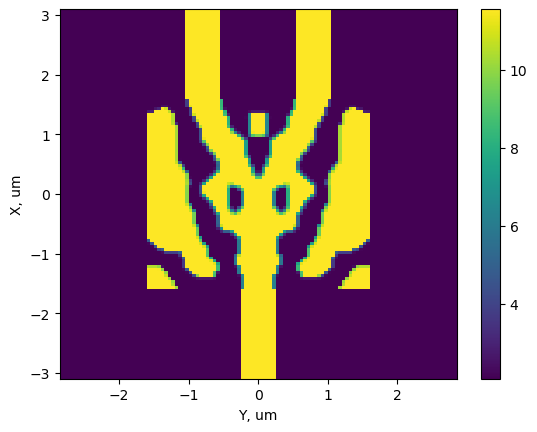

In [3]:
### Implementation of FDFD

# Define the device on Yee grid
splitter = np.load('eps.npy')                # epsilon distribution of splitter 
x = np.load('x.npy')                         # X coordinate
y = np.load('y.npy')                         # Y coordinate

xx, yy = np.meshgrid(x, y)

plt.figure()
plt.pcolormesh(y, x, splitter)
plt.xlabel('Y, um')
plt.ylabel('X, um')
plt.colorbar()

/tmp/ipykernel_421/1229564654.py:248: ComplexWarning: Casting complex values to real discards the imaginary part
  fscr_on_grid[nx,:] = (Esrc*np.exp(-1j*k0*neff*nx*dx))


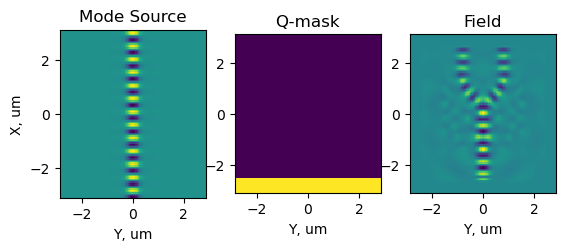

In [4]:
lam0 = 1.55                                  # wavelength
k0 = 2*np.pi/lam0                            # wave vector

eps_space = splitter[10, 10]                 # epsilon value of cell
eps_splitter = splitter[40, 60]              # epsilon value of splitter

MODE = 'E'                                   # define mode
NMODES = 4                                   # number of modes to find eigenvalues and eigenvectors

Nx = len(x)                                  # number of points at the x-axis
Ny = len(y)                                  # number of points at the y-axis

dx = np.abs(np.abs(x[0]) - np.abs(x[1]))     # resolution parameter at the x-axis
dy = np.abs(np.abs(y[0]) - np.abs(y[1]))     # resolution parameter at the y-axis

# 2X GRID
Nx2 = 2*Nx                                   # number of points at the x-axis for 2x grid
dx2 = dx/2                                   # resolution parameter at the x-axis for 2x grid
Ny2 = 2*Ny                                   # number of points at the x-axis for 2y grid
dy2 = dy/2                                   # resolution parameter at the x-axis for 2y grid

UR2 = np.ones((Nx2,Ny2))                             # define Magnetic Permeability of splitter at the 2x grid
ER2 = Interpolation_to_2x_grid(splitter, [Nx, Ny])   # define Electric Permittivity of splitter at the 2x grid

NPML   = [11, 11, 11, 11]
NS  = np.array([Nx, Ny])
RES = np.array([dx, dy])
coord_source = NPML[0] + 1                       # Location coordinate of mode source
coord_tfsf = NPML[0] + 1                         # Location coordinate of total field/scattered field boundary

Q_on_grid = np.zeros((Nx,Ny))                    # create empty numpy array for distribution mode source cross the grid
Q_on_grid[0:coord_tfsf,:] = 1                    # 1's - scattered field, 0's - total field

f = performFDFD(NPML, NS, RES, coord_source, k0, MODE, coord_tfsf, Q_on_grid)

Transmittance on left waveguide:   0.47899112838160124
Transmittance on right waveguide:  0.47919142601463754


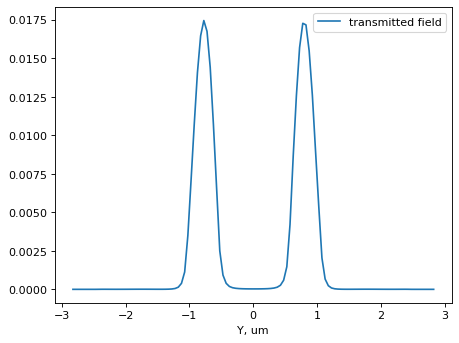

In [5]:
# EXTRACT FIELDS
nx   = Nx - NPML[1] -1 
nx0 = NPML[0] + 3
ftrn = f[nx,:]
T_left_waveguide = (np.sum(np.abs(ftrn[:int(Ny/2)])**2)) / (np.sum(np.abs(f[nx0])**2))
T_right_waveguide = (np.sum(np.abs(ftrn[int(Ny/2):])**2)) / (np.sum(np.abs(f[nx0])**2))

print('Transmittance on left waveguide:  ', T_left_waveguide)
print('Transmittance on right waveguide: ', T_right_waveguide)


plt.figure(dpi=80)
plt.plot(y, np.abs(ftrn)**2, label = 'transmitted field')
# plt.plot(np.abs(f[nx0])**2, label = 'incident field')
plt.xlabel('Y, um')
plt.legend()
# plt.ylim(0, 0.15)

/tmp/ipykernel_421/1229564654.py:248: ComplexWarning: Casting complex values to real discards the imaginary part
  fscr_on_grid[nx,:] = (Esrc*np.exp(-1j*k0*neff*nx*dx))


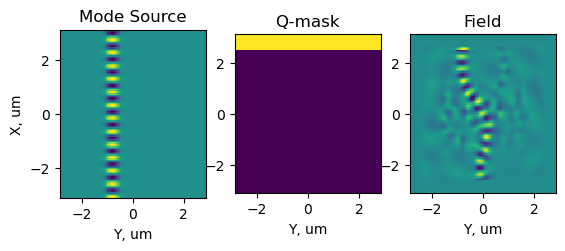

In [6]:
NPML   = [11, 11, 11, 11]
NS  = np.array([Nx, Ny])
RES = np.array([dx, dy])
coord_source = Nx - NPML[0] - 1                       # Location coordinate of mode source
coord_tfsf = NPML[0] + 1                         # Location coordinate of total field/scattered field boundary

nx = Nx - NPML[0] - 1                        # Location coordinate of total field/scattered field boundary
Q_on_grid = np.ones((Nx,Ny))                 # create empty numpy array for distribution mode source cross the grid
Q_on_grid[0:nx,:] = 0                        # 1's - scattered field, 0's - total field

f = performFDFD(NPML, NS, RES, coord_source, k0, MODE, coord_tfsf, Q_on_grid)

/tmp/ipykernel_421/1229564654.py:248: ComplexWarning: Casting complex values to real discards the imaginary part
  fscr_on_grid[nx,:] = (Esrc*np.exp(-1j*k0*neff*nx*dx))


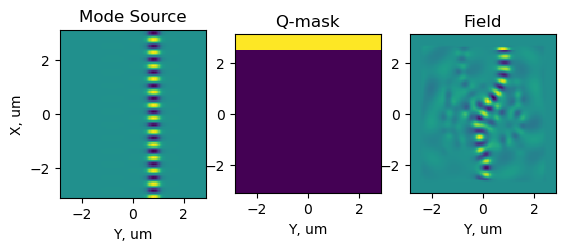

In [7]:
NPML   = [11, 11, 11, 11]
NS  = np.array([Nx, Ny])
RES = np.array([dx, dy])
coord_source = Nx - NPML[0] - 1                       # Location coordinate of mode source
coord_tfsf = NPML[0] + 1                         # Location coordinate of total field/scattered field boundary

nx = Nx - NPML[0] - 1                        # Location coordinate of total field/scattered field boundary
Q_on_grid = np.ones((Nx,Ny))                 # create empty numpy array for distribution mode source cross the grid
Q_on_grid[0:nx,:] = 0                        # 1's - scattered field, 0's - total field

f = performFDFD(NPML, NS, RES, coord_source, k0, MODE, coord_tfsf, Q_on_grid)